In [1]:
import sys, glob, os
SPARK_HOME = "/wd/software/spark-2.3.1-bin-hadoop2.7"
#SPARK_HOME=os.environ['SPARK_HOME']
sys.path.append(SPARK_HOME + "/python")
sys.path.append(glob.glob(SPARK_HOME + "/python/lib/py4j*.zip")[0])
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.storagelevel import StorageLevel


spark = (SparkSession
         .builder
         .config("spark.master", "local[*]")
         .config("spark.driver.memory", "56G")
         .config("spark.sql.shuffle.partitions", 32)
         .config("spark.local.dir", "/spark-scratch")
         .config("spark.executor.extraJavaOptions", "-XX:+UseG1GC")
         .enableHiveSupport()
         .getOrCreate())

sc = spark.sparkContext

print(sc.uiWebUrl)

http://einext02:4040


# ERD
https://drive.google.com/open?id=1dHAdBT84rEDf3WiE7FSfFrpnGQVL0wUSsWAGEH7ywZg

In [2]:
from datetime import datetime
import matplotlib.pyplot as plt

import pyspark.sql.functions as F
from pyspark.sql.window import Window
import numpy as np
import pandas as pd
from sklearn import metrics


pd.options.display.max_columns = 1000
pd.options.display.max_rows = 10

fast_mode = True

%matplotlib inline


from IPython.core.magic import register_line_magic


@register_line_magic
def show(line, n = 5):
    return eval(line).limit(n).toPandas()

@register_line_magic
def sql(line, n = 10):
    return spark.sql(line)

In [3]:
base_path = "/data/kaggle/outbrain_ctr/parquet/"

def cache_df(df, name, sorage_level = StorageLevel.MEMORY_ONLY):
    df.createOrReplaceTempView(name)
    spark.catalog.cacheTable(name)

def load(name, rebase_timestamp = False, cache = True):
    df = spark.read.load(base_path + name)
        
    if rebase_timestamp and "timestamp" in df.columns:
        df = df.withColumn("timestamp"
            , F.expr("cast(from_unixtime(cast((timestamp + 1465876799998)/1000 as int)) as timestamp)"))
    if cache:
        cache_df(df, name)

    df.alias(name)
    print("Number of partitions for df %s: %d" % (name, df.rdd.getNumPartitions()))
        
    return df

In [4]:
!ls -1 /data/kaggle/outbrain_ctr/parquet/

clicks_test
clicks_train
df_null_removed
df_null_removed2
documents_categories
documents_entities
documents_meta
documents_topics
events
lrModel
lrModel2
merged_enriched
page_views
page_views_sample
promoted_content
sample_submission


# Clicks

In [5]:
clicks_train = load("clicks_train")
clicks_train.show()

Number of partitions for df clicks_train: 11
+----------+------+-------+
|display_id| ad_id|clicked|
+----------+------+-------+
|         1| 42337|      0|
|         1|139684|      0|
|         1|144739|      1|
|         1|156824|      0|
|         1|279295|      0|
|         1|296965|      0|
|         2|125211|      0|
|         2|156535|      0|
|         2|169564|      0|
|         2|308455|      1|
|         3| 71547|      0|
|         3| 95814|      0|
|         3|152141|      0|
|         3|183846|      0|
|         3|228657|      1|
|         3|250082|      0|
|         4|149930|      0|
|         4|153623|      1|
|         4|184709|      0|
|         4|186849|      0|
+----------+------+-------+
only showing top 20 rows



In [6]:
clicks_test = load("clicks_test")
clicks_test.show()

Number of partitions for df clicks_test: 8
+----------+------+
|display_id| ad_id|
+----------+------+
|  17662676|141437|
|  17662676|169868|
|  17662676|236063|
|  17662676|414970|
|  17662677|114004|
|  17662677|115935|
|  17662677|133772|
|  17662677|156669|
|  17662678|123742|
|  17662678|157185|
|  17662678|169432|
|  17662678|366611|
|  17662679|111055|
|  17662679|130942|
|  17662679|160452|
|  17662679|190318|
|  17662679|207568|
|  17662679|233512|
|  17662680|141437|
|  17662680|163614|
+----------+------+
only showing top 20 rows



In [7]:
clicks_train.count(), clicks_test.count()

(87141731, 32225162)

Distinct count of ad_id in training and test dataset

In [8]:
%time clicks_train.select("ad_id").distinct().count(), clicks_test.select("ad_id").distinct().count()

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 2.61 s


(478950, 381385)

Common ad_id in training and test datasets

In [9]:
%time clicks_train.select("ad_id").intersect(clicks_test.select("ad_id")).count()

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 11.9 s


316035

In [10]:
1- 316035/381385

0.17134916160834857

17% of ad_id in testing dataset are unique.

Calculate CTR on training dataset. Note, we cannot calculate the CTR on test dataset since clicked column is provded the value. In fact, the rask is to predict the probability of click.

In [11]:
ctrs = clicks_train.groupBy("ad_id")\
.agg(F.expr("sum(clicked)/count(*)").alias("ctr"), F.count("*").alias("view_count"))

ctrs.show()

+------+--------------------+----------+
| ad_id|                 ctr|view_count|
+------+--------------------+----------+
| 71547| 0.08026711185308848|     14975|
|152141|  0.1633811230585424|     20088|
| 35982|  0.3194444444444444|       144|
|220315|  0.0814290895901342|     11028|
| 28347| 0.21975410210704327|     21879|
| 55988| 0.08457994066780282|     15843|
| 51445|  0.2615935392556823|     12011|
|198151| 0.14902102973168962|     71708|
| 47081| 0.46573604060913704|       788|
| 86281| 0.16210065645514224|     11425|
|  8748|  0.2739398855391825|     22191|
|271623| 0.06908981676179032|      3329|
|102724|  0.5151337359792925|     28975|
| 73754| 0.04944791166586654|      2083|
|232276|0.029014177382129903|      3033|
|107571|  0.2857142857142857|        42|
|167350| 0.16086459524056948|      9623|
|279899|  0.3333333333333333|         3|
|159405|  0.3200608122782886|     13813|
| 14400|  0.4529262086513995|      1965|
+------+--------------------+----------+
only showing top

In [12]:
%time ctrs.select("ctr").describe().show()

+-------+-------------------+
|summary|                ctr|
+-------+-------------------+
|  count|             478950|
|   mean| 0.1432241011540594|
| stddev|0.21768444463682177|
|    min|                0.0|
|    max|                1.0|
+-------+-------------------+

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.81 s


Median CTR

In [13]:
%time ctrs.selectExpr("percentile(ctr, 0.5)").show()

+---------------------------------------+
|percentile(ctr, CAST(0.5 AS DOUBLE), 1)|
+---------------------------------------+
|                    0.05172413793103448|
+---------------------------------------+

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.9 s


In [14]:
ctrs.filter("ad_id = 182320").show()

+------+------------------+----------+
| ad_id|               ctr|view_count|
+------+------------------+----------+
|182320|0.7308917197452229|       628|
+------+------------------+----------+



Find 99, 95 and 90 percentile values of the view counts of the ads.

In [15]:
view_counts = ctrs.select("view_count").toPandas()
np.percentile(view_counts["view_count"], [99, 95, 90])

array([3598.51,  305.  ,   81.  ])

To build confidence on the CTR, filter out the ads with fewer than 100 views (approx 99 percentile value)

CPU times: user 628 ms, sys: 24 ms, total: 652 ms
Wall time: 1.9 s


Text(0,0.5,'Frquency (normalized)')

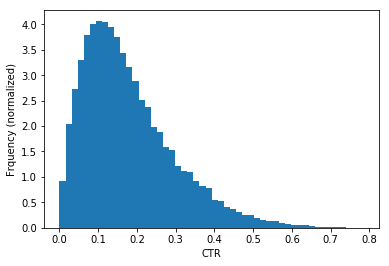

In [16]:
%time ctrs.filter("view_count>100").select("ctr").toPandas()["ctr"].plot.hist(bins = 50, density = True)
plt.xlabel("CTR")
plt.ylabel("Frquency (normalized)")

Consier, the CTR as baseline for click prediction. Using CTR as based, calculate the MAP (mean avg precision)

In [17]:
#y_pred = clicks_train.join(ctrs.select("ad_id", "ctr"), on = ["ad_id"], how="left").select("ctr").toPandas()["ctr"]
#y_true = clicks_train.select("clicked").toPandas()["clicked"]

#%time metrics.average_precision_score(y_true, y_pred)

In [18]:
clicks_test_baseline = clicks_test.join(ctrs.select("ad_id", "ctr"), on = ["ad_id"], how="left")
clicks_test_baseline.show()

+-----+----------+-------------------+
|ad_id|display_id|                ctr|
+-----+----------+-------------------+
|   18|  18637093|                0.0|
|   38|  19842301|               null|
|   38|  21227007|               null|
|   70|  22445644|               null|
|   93|  17994591|0.11956521739130435|
|   93|  18082288|0.11956521739130435|
|   93|  18138846|0.11956521739130435|
|   93|  18139717|0.11956521739130435|
|   93|  18146038|0.11956521739130435|
|   93|  18209662|0.11956521739130435|
|   93|  18242010|0.11956521739130435|
|   93|  18265668|0.11956521739130435|
|   93|  18299525|0.11956521739130435|
|   93|  18300420|0.11956521739130435|
|   93|  18341642|0.11956521739130435|
|   93|  18419095|0.11956521739130435|
|   93|  18422601|0.11956521739130435|
|   93|  18427146|0.11956521739130435|
|   93|  18480210|0.11956521739130435|
|   93|  18525463|0.11956521739130435|
+-----+----------+-------------------+
only showing top 20 rows



In [19]:
clicks_test_baseline.groupBy("display_id").count()

DataFrame[display_id: int, count: bigint]

In [20]:
clicks_test_baseline.groupBy("display_id").agg(F.sum("ctr").alias("ap")).selectExpr("avg(ap)").show()

+------------------+
|           avg(ap)|
+------------------+
|0.9835441908732905|
+------------------+



How many ads are there for each display_id?

In [21]:
%time clicks_train.groupBy("display_id").count().select("count").distinct().show()

+-----+
|count|
+-----+
|    9|
|    3|
|    6|
|    7|
|    5|
|    8|
|   11|
|    4|
|    2|
|   12|
|   10|
+-----+

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 4.03 s


Does each display_id in the training dataset has atleast one click?

In [22]:
%time clicks_train.groupBy("display_id").agg(F.sum("clicked").alias("clicks")).filter("clicks=0").count()

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 4.31 s


0

So, each display_id has atleast one click. Does it display_id in the training dataset has more than click?

In [23]:
%time clicks_train.groupBy("display_id").agg(F.sum("clicked").alias("clicks")).filter("clicks>1").count()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.85 s


0

So, each display_id in the clicks dataset has only one click.

# Page Views

In [24]:
if fast_mode:
    print("Loading page_view sample dataset")
    page_views = load("page_views_sample", rebase_timestamp=True, cache=True)
    #page_views = page_views.sample(False, 0.01, 1)
    #cache_df(page_views, "page_views")
else:
    print("Loading full page_view dataset")
    page_views = load("page_views", rebase_timestamp=True, cache=False)
page_views.printSchema()

Loading page_view sample dataset
Number of partitions for df page_views_sample: 8
root
 |-- uuid: string (nullable = true)
 |-- document_id: integer (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- platform: integer (nullable = true)
 |-- geo_location: string (nullable = true)
 |-- traffic_source: integer (nullable = true)



In [25]:
page_views.show()

+--------------+-----------+-------------------+--------+------------+--------------+
|          uuid|document_id|          timestamp|platform|geo_location|traffic_source|
+--------------+-----------+-------------------+--------+------------+--------------+
|289a8ac9e3b3be|     647313|2016-06-14 23:30:43|       1|       PK>08|             1|
|2cd20abba0d948|     647313|2016-06-14 18:19:16|       3|   US>CA>804|             1|
|6149469c04c102|     647313|2016-06-14 10:12:32|       1|       AU>01|             1|
|f3bca9d885121d|     647313|2016-06-15 06:07:45|       2|   US>KS>616|             1|
|594de491d7a3d1|     647313|2016-06-14 13:09:20|       1|   US>CA>807|             1|
|b5fe86af022f0c|     647313|2016-06-14 12:13:02|       3|       GB>H9|             1|
|56bb88f5111d21|     647313|2016-06-14 11:02:45|       1|       SI>61|             1|
|82a3dae458fd43|     647313|2016-06-14 15:46:58|       1|       MU>17|             1|
|4323bb94758e52|     647313|2016-06-14 10:04:50|      

Page views table is nearly 100 GB in decompressed csv file. How many records are there?

In [26]:
page_views.count()

9999999

Does each record in page_views have timestamp?

In [27]:
%time page_views.filter("isnull(timestamp)").count()

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 47.7 ms


0

In [28]:
stats = page_views.selectExpr("count(distinct(uuid)) as users"
                      , "count(distinct(document_id)) as documents"
                      , "count(distinct(geo_location)) as locations")
%time stats.show()

+-------+---------+---------+
|  users|documents|locations|
+-------+---------+---------+
|9202149|    59849|     2964|
+-------+---------+---------+

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.37 s


Some users are more frequent visitor that the others. Find the number of visitors based on the view counts.

In [29]:
page_views_by_user = page_views.groupBy("uuid").count().groupBy("count").count()\
                    .toDF("view_count", "num_users").toPandas().sort_values("view_count")
page_views_by_user

,view_count,num_users
11,1,8546933
9,2,549587
1,3,80770
8,4,16394
4,5,6165
...,...,...
0,9,90
12,10,22
6,11,6
10,12,2


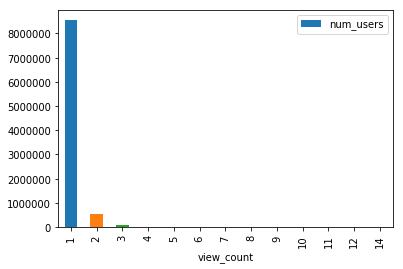

In [30]:
page_views_by_user.iloc[:20, :].plot.bar("view_count", "num_users")

Number of unique users

In [31]:
users_distinct_count = page_views_by_user.num_users.sum()

Average page views per user 

In [32]:
(page_views_by_user.num_users * page_views_by_user.view_count).sum()/users_distinct_count

1.0867025734966909

Cumulative Percentual

In [33]:
page_views_by_user["cum_percentual"] = page_views_by_user.num_users.cumsum()/users_distinct_count
page_views_by_user

,view_count,num_users,cum_percentual
11,1,8546933,0.928798
9,2,549587,0.988521
1,3,80770,0.997299
8,4,16394,0.999080
4,5,6165,0.999750
...,...,...,...
0,9,90,0.999997
12,10,22,0.999999
6,11,6,1.000000
10,12,2,1.000000


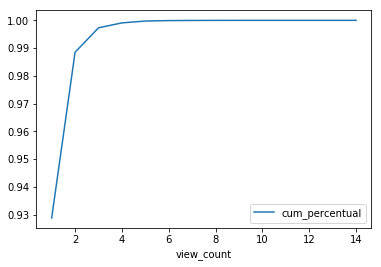

In [34]:
page_views_by_user.iloc[:20, :].plot.line(x = "view_count", y = "cum_percentual")

In [35]:
page_views_by_user.tail(10)

,view_count,num_users,cum_percentual
8,4,16394,0.999080
4,5,6165,0.999750
2,6,1453,0.999908
3,7,479,0.999960
5,8,247,0.999987
0,9,90,0.999997
12,10,22,0.999999
6,11,6,1.000000
10,12,2,1.000000
7,14,1,1.000000


Page views by platform

In [36]:
page_views_by_platform = page_views.groupBy("platform")\
.count().toPandas().set_index("platform").sort_index()
page_views_by_platform

,count
platform,
1,4403345
2,4678799
3,917855


Text(0.5,1,'Page views by platform')

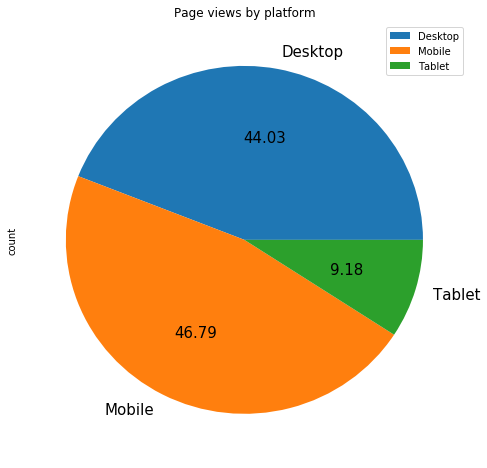

In [37]:
page_views_by_platform.plot.pie(y = "count", labels = ["Desktop", "Mobile", "Tablet"]
                    , figsize = (8, 8), autopct = "%.2f", fontsize = 15)
plt.title("Page views by platform")

Page views by traffic source

In [38]:
page_views_by_traffic_source = page_views.groupBy("traffic_source").count().toPandas()
page_views_by_traffic_source = page_views_by_traffic_source.set_index("traffic_source").sort_index()
page_views_by_traffic_source

,count
traffic_source,
1,6668961
2,1667170
3,1663868


Text(0.5,1,'Page views by traffic source')

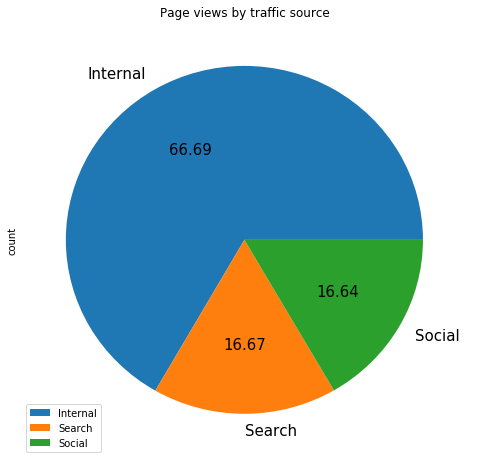

In [39]:
page_views_by_traffic_source.plot.pie(y = "count", labels = ["Internal", "Search", "Social"]
                    , figsize = (8, 8), autopct = "%.2f", fontsize = 15)
plt.title("Page views by traffic source")

# Events

In [40]:
events = load("events")
events.show()

Number of partitions for df events: 9
+----------+--------------+-----------+---------+--------+------------+
|display_id|          uuid|document_id|timestamp|platform|geo_location|
+----------+--------------+-----------+---------+--------+------------+
|         1|cb8c55702adb93|     379743|       61|       3|   US>SC>519|
|         2|79a85fa78311b9|    1794259|       81|       2|   US>CA>807|
|         3|822932ce3d8757|    1179111|      182|       2|   US>MI>505|
|         4|85281d0a49f7ac|    1777797|      234|       2|   US>WV>564|
|         5|8d0daef4bf5b56|     252458|      338|       2|       SG>00|
|         6|7765b4faae4ad4|    1773517|      395|       3|   US>OH>510|
|         7|2cc3f6457d16da|    1149661|      602|       2|   US>MT>762|
|         8|166fc654d73c98|    1330329|      638|       2|   US>PA>566|
|         9|9dddccf70f6067|    1772126|      667|       1|   US>FL>528|
|        10|b09a0e92aa4d17|     157455|      693|       1|          US|
|        11|602e210c5831e5

In [41]:
events = events.withColumn("timestamp", F.expr("from_unixtime(cast((timestamp + 1465876799998)/1000 as int))"))
events.show()

+----------+--------------+-----------+-------------------+--------+------------+
|display_id|          uuid|document_id|          timestamp|platform|geo_location|
+----------+--------------+-----------+-------------------+--------+------------+
|         1|cb8c55702adb93|     379743|2016-06-14 09:30:00|       3|   US>SC>519|
|         2|79a85fa78311b9|    1794259|2016-06-14 09:30:00|       2|   US>CA>807|
|         3|822932ce3d8757|    1179111|2016-06-14 09:30:00|       2|   US>MI>505|
|         4|85281d0a49f7ac|    1777797|2016-06-14 09:30:00|       2|   US>WV>564|
|         5|8d0daef4bf5b56|     252458|2016-06-14 09:30:00|       2|       SG>00|
|         6|7765b4faae4ad4|    1773517|2016-06-14 09:30:00|       3|   US>OH>510|
|         7|2cc3f6457d16da|    1149661|2016-06-14 09:30:00|       2|   US>MT>762|
|         8|166fc654d73c98|    1330329|2016-06-14 09:30:00|       2|   US>PA>566|
|         9|9dddccf70f6067|    1772126|2016-06-14 09:30:00|       1|   US>FL>528|
|        10|b09a

In [42]:
events = load("events", rebase_timestamp=True)

Number of partitions for df events: 9


In [43]:
events.count()

23120126

Find distinct count of users, document, and location

In [44]:
%time events.selectExpr("count(distinct uuid)", "count(distinct document_id)", "count(distinct geo_location)").first()

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 8 s


Row(count(DISTINCT uuid)=19794967, count(DISTINCT document_id)=894060, count(DISTINCT geo_location)=2988)

Is the display_id unique in the events dataset?

In [45]:
%time events.groupBy("display_id").count().filter("count>1").count()

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 4.64 s


0

Do all the display_id in the clicks_train present in events?

In [46]:
%time clicks_train.select("display_id").distinct().join(events, on = ["display_id"], how = "left_anti").count()

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 5.68 s


0

So, display_id for each record in clicks_train is present in events dataset.

Check the same for clicks_test dataset.

In [47]:
%time clicks_test.select("display_id").distinct().join(events, on = ["display_id"], how = "left_anti").count()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.21 s


0

Average events by user

In [48]:
events.selectExpr("count(*)/count(distinct uuid) avg_event_by_user").first()

Row(avg_event_by_user=1.1679800223966021)

Does the timestamp exist for each record in events?

In [49]:
events.filter("isnull(timestamp)").count()

0

Does the timestamp in clicks_train and clicks_test have overlap?

In [50]:
%time clicks_train.join(events, on = ["display_id"]).select("timestamp").describe().show()

+-------+
|summary|
+-------+
|  count|
|   mean|
| stddev|
|    min|
|    max|
+-------+

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 18.6 ms


In [51]:
%time clicks_test.join(events, on = ["display_id"]).select("timestamp").describe().show()

+-------+
|summary|
+-------+
|  count|
|   mean|
| stddev|
|    min|
|    max|
+-------+

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 31.5 ms


Clearly, the date ranges of training and test data overlap.

# Alignment between Events and Page Views

Number of page views without matching event

How many events have matching page views by uuid and document_id

How many events have no page views

How many views records have not matching events 

A given user might visit the same page more than once. Show sample events for which multiple page_views exist.  

Show the distribution of number of ditinct users who view the same document multiple times

In [52]:
def join_views_and_events(columns):
    df1 = page_views.select(*columns).withColumn("page_views", F.lit(1)).withColumn("events", F.lit(0))
    df2 = events.select(*columns).withColumn("page_views", F.lit(0)).withColumn("events", F.lit(1))
    df3 = df1.union(df2)
    df4 = df3.groupBy(columns).agg(
                F.sum("page_views").alias("page_views_count"), 
                F.sum("events").alias("events_count"))
    return df4

In [53]:
# Cache output to disk. The dataframe is too large to hold in the memory of the current machine 
views_and_event = join_views_and_events(["uuid", "document_id"]).persist(StorageLevel.DISK_ONLY)
views_and_event.show()

+--------------+-----------+----------------+------------+
|          uuid|document_id|page_views_count|events_count|
+--------------+-----------+----------------+------------+
|3286c54a862512|     647776|               1|           0|
|a29f99948e908e|     647776|               1|           0|
|1dd38cfc32d0af|     647776|               1|           0|
|2ebe105af88084|     647776|               1|           0|
|fc4f1e271ab611|     647776|               1|           0|
|7a14dda54e7f60|     649004|               1|           0|
|7c04b579125457|     649161|               1|           0|
|df1f16aaeff918|     649161|               1|           0|
|7932260aef663f|     649395|               1|           0|
|b78c5990704b55|     649395|               1|           0|
|c9cc4498d587e5|     649395|               1|           0|
|d0f57454f9bd8d|     649395|               1|           0|
|514bdfac720462|     649395|               1|           0|
|5e981a9aa49864|     649707|               1|           

How many user-document combination does not have any click on ads?

In [54]:
%time views_and_event.filter("page_views_count > 0 and events_count = 0").count()

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 10.2 s


9877706

How many user-doc combination does have machine record in page views?

In [55]:
%time views_and_event.filter("page_views_count = 0 and events_count > 0").count()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 367 ms


22468988

Considering events represents the page views that have got clicks, what fraction of page views got clicks?  

In [56]:
events.count()/page_views.count()

2.312012831201283

Let's take a sample uuid and document_id to see whether the event records have a matching page_views record.

In [57]:
%time page_views.filter("uuid = 'a34004004c3e50' and document_id = 140264").show()

+----+-----------+---------+--------+------------+--------------+
|uuid|document_id|timestamp|platform|geo_location|traffic_source|
+----+-----------+---------+--------+------------+--------------+
+----+-----------+---------+--------+------------+--------------+

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 91.1 ms


In [58]:
%time events.filter("uuid = 'a34004004c3e50' and document_id = 140264").show()

+----------+--------------+-----------+-------------------+--------+------------+
|display_id|          uuid|document_id|          timestamp|platform|geo_location|
+----------+--------------+-----------+-------------------+--------+------------+
|      1341|a34004004c3e50|     140264|2016-06-14 09:31:33|       1|   US>CA>868|
|  17427544|a34004004c3e50|     140264|2016-06-16 19:24:19|       1|   US>CA>868|
+----------+--------------+-----------+-------------------+--------+------------+

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.34 s


Hypothesis: The page views record come web server logs. Events some user tracking devices such as omniture, google analytics. User may open the page, the after sometime, user may choose to view an ad. 

User may view a page more than once. Find how many users have viewed the same page more than once. 

In [59]:
repeated_page_views = page_views.groupBy(["uuid", "document_id"]).count()\
        .filter("count > 1").orderBy(F.desc("count"))
repeated_page_views.show()

+----+-----------+-----+
|uuid|document_id|count|
+----+-----------+-----+
+----+-----------+-----+



In [60]:
repeated_page_views.count()

0

Look at a sample uuid who has repeated visited a page to observe the pattern in the source, location and timestamp

In [61]:
if repeated_page_views.count()>0:
    sample_record = repeated_page_views.sample(True, 0.1).take(1)[0]
    page_views.filter(F.col("uuid") == sample_record.uuid)\
        .filter(F.col("document_id") == sample_record.document_id).show()

# Advertisement (Promopoted Content)

In [62]:
promoted_contents = load("promoted_content")
promoted_contents.show()

Number of partitions for df promoted_content: 4
+-----+-----------+-----------+-------------+
|ad_id|document_id|campaign_id|advertiser_id|
+-----+-----------+-----------+-------------+
|    1|       6614|          1|            7|
|    2|     471467|          2|            7|
|    3|       7692|          3|            7|
|    4|     471471|          2|            7|
|    5|     471472|          2|            7|
|    6|      12736|          1|            7|
|    7|      12808|          1|            7|
|    8|     471477|          2|            7|
|    9|      13379|          1|            7|
|   10|      13885|          1|            7|
|   11|      14230|          1|            7|
|   12|     446701|         10|           19|
|   13|     471499|         10|           19|
|   14|     471500|         10|           19|
|   15|     471501|         10|           19|
|   16|     471514|         17|           19|
|   17|     471517|         10|           19|
|   18|     471518|         10| 

In [63]:
promoted_contents.count()

559583

Promoted_content stores the meta of the ads. Double check the ad_id is unique in this dataset.

In [64]:
%time promoted_contents.groupBy("ad_id").count().filter("count>1").count()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 135 ms


0

How many unique campaigns, documents and advertisers are there?

In [65]:
%time promoted_contents\
.selectExpr("count(distinct document_id)", "count(distinct campaign_id)", "count(distinct advertiser_id)").first()

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 214 ms


Row(count(DISTINCT document_id)=185709, count(DISTINCT campaign_id)=34675, count(DISTINCT advertiser_id)=4385)

Does ad_id in the clicks dataset have meta data info in promoted_contents?

In [66]:
%time (clicks_train.select("ad_id").union(clicks_test.select("ad_id"))\
       .join(promoted_contents, on = ["ad_id"], how = "leftanti").count())

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 3.71 s


0

So, all the ad_id in clicks dataset exist in the promoted_contents. 

Find average CTR for campaign

In [67]:
avg_ctr_by_campaign = promoted_contents.join(ctrs, on = "ad_id").groupBy("campaign_id")\
.agg(F.avg("ctr").alias("avg_ctr"))

avg_ctr_by_campaign.show()

+-----------+-------------------+
|campaign_id|            avg_ctr|
+-----------+-------------------+
|      12020|0.18853094256899317|
|      15551|0.14168937329700274|
|      16636|0.06654206156723358|
|      17774| 0.4740740740740741|
|      10710|0.07173178014624783|
|       7857|0.15448798511873105|
|       8748|   0.13014925725663|
|      28587|0.03608090199020851|
|      26563|0.05487204724409449|
|      25870|0.09421250207776988|
|      12787|0.26873419406362303|
|      24189|0.12057582351582147|
|        343| 0.1642336045511124|
|      22274|0.14866234594342462|
|      27610|0.12141843236348225|
|      25673| 0.0909153570443893|
|        692|0.10861946684564693|
|      17645|0.12021702251393619|
|      23815|  0.085025248657077|
|      26133| 0.1047878333543433|
+-----------+-------------------+
only showing top 20 rows



Find avg ctr by advertiser.

In [68]:
avg_ctr_by_advertiser = promoted_contents.join(ctrs, on = "ad_id").groupBy("advertiser_id")\
.agg(F.avg("ctr").alias("avg_ctr"))

avg_ctr_by_advertiser.show()

+-------------+-------------------+
|advertiser_id|            avg_ctr|
+-------------+-------------------+
|         2349|0.10883058103462902|
|         3829| 0.2068642691859514|
|         1283|0.14176344970802937|
|          434| 0.1043910399182465|
|         2030|0.10217395554446719|
|         2447|0.05872570281791586|
|         2625|0.13082804384293295|
|           38|0.13581588111063284|
|         1633|0.20279203966409717|
|         3404|0.03207982667240285|
|         1809|0.15295881650970958|
|         2260|0.35096740188296494|
|          881| 0.1252447139156763|
|         1557|0.09639892315222712|
|         1830| 0.2122485949912904|
|         2116| 0.1282686945248045|
|         2840|0.23191125858194017|
|         3572|0.12020942448693174|
|          784|0.08288804563485187|
|         2859|0.19682314282065358|
+-------------+-------------------+
only showing top 20 rows



Find avg ctr by document.

In [69]:
avg_ctr_by_document = promoted_contents.join(ctrs, on = "ad_id").groupBy("document_id")\
.agg(F.avg("ctr").alias("avg_ctr"))

avg_ctr_by_document.show()

+-----------+--------------------+
|document_id|             avg_ctr|
+-----------+--------------------+
|    1087952| 0.33327873327873325|
|     870875| 0.24400340797438524|
|    1377696|0.048441767634379414|
|    1146963| 0.19168084171412803|
|    1083829| 0.32597524434580355|
|     378777| 0.08661417322834646|
|    1247211|  0.2608837247293875|
|     902349|0.058823529411764705|
|     907267| 0.03737655352703233|
|    1273596| 0.26410511426215816|
|    1333191|  0.1767042599220612|
|     876083| 0.08421440203631031|
|    1767220| 0.16518679146475518|
|    1603476| 0.19174833310958966|
|    1561030| 0.05284776441477035|
|    1176283|  0.3650056262723164|
|     630595|0.014084507042253521|
|    1590983|                 0.0|
|    1154277| 0.19185631204008377|
|    1326394|  0.0379591665969375|
+-----------+--------------------+
only showing top 20 rows



# Document Attributes

### Document Meta Data

In [70]:
documents_meta = load("documents_meta")
documents_meta.show(5, False)

Number of partitions for df documents_meta: 8
+-----------+---------+------------+-------------------+
|document_id|source_id|publisher_id|publish_time       |
+-----------+---------+------------+-------------------+
|788428     |579      |9           |2015-03-16 00:00:00|
|864787     |579      |9           |2011-08-22 00:00:00|
|817971     |579      |9           |2015-07-13 00:00:00|
|806663     |579      |9           |2015-06-01 00:00:00|
|796001     |579      |9           |2015-04-03 00:00:00|
+-----------+---------+------------+-------------------+
only showing top 5 rows



In [71]:
documents_meta.count()

2999334

Verify whether the document_id is unique in document_meta.

In [72]:
documents_meta.groupby("document_id").count().filter("count>1").count()

0

How many source_ids are there?

In [73]:
documents_meta.select("source_id").distinct().count()

14395

How many publisher_ids are there?

In [74]:
documents_meta.select("publisher_id").distinct().count()

1260

### Document Categories

In [75]:
documents_categories = load("documents_categories").drop_duplicates(["document_id", "category_id"])
documents_categories.printSchema()
documents_categories.show(5, False)

Number of partitions for df documents_categories: 8
root
 |-- document_id: integer (nullable = true)
 |-- category_id: integer (nullable = true)
 |-- confidence_level: double (nullable = true)

+-----------+-----------+----------------+
|document_id|category_id|confidence_level|
+-----------+-----------+----------------+
|2416431    |1407       |0.87841876      |
|2260393    |1702       |0.92            |
|917692     |1702       |0.92            |
|1786173    |1706       |0.07            |
|1783554    |1709       |0.07            |
+-----------+-----------+----------------+
only showing top 5 rows



In [76]:
documents_categories.count()

5481474

In [77]:
documents_categories.select("category_id").distinct().count()

97

category_id is not indexed. Using string indexer to index it. One Hot Encoding is another option. Here I am not doing it because the I want to use the confidence_level to weigh in. 

In [78]:
from pyspark.ml.feature import StringIndexer

#String indexer required string column
documents_categories = documents_categories.withColumn("category_id", F.expr("cast(category_id as string)")) 

if "id" in documents_categories.columns:
    documents_categories = documents_categories.drop("id")

category_indexer = StringIndexer(inputCol="category_id", outputCol="id")
documents_categories = category_indexer.fit(documents_categories).transform(documents_categories)

documents_categories.show()

+-----------+-----------+----------------+----+
|document_id|category_id|confidence_level|  id|
+-----------+-----------+----------------+----+
|    2416431|       1407|      0.87841876|12.0|
|    2260393|       1702|            0.92| 1.0|
|     917692|       1702|            0.92| 1.0|
|    1786173|       1706|            0.07|13.0|
|    1783554|       1709|            0.07|55.0|
|    1776902|       1806|     0.597394548|20.0|
|    1784492|       1702|     0.556040824| 1.0|
|    1812275|       1903|            0.92|15.0|
|    1762888|       1613|     0.904981736|38.0|
|    1811648|       1702|            0.92| 1.0|
|    1110915|       1702|     0.622750116| 1.0|
|     983795|       1702|     0.582905652| 1.0|
|    1093318|       2004|            0.07| 7.0|
|     984200|       1302|     0.436507432|48.0|
|    1913424|       1706|            0.07|13.0|
|    2061034|       1702|     0.042858662| 1.0|
|    1972828|       1702|            0.92| 1.0|
|    1904284|       1706|            0.0

Group the data by document_id and pack the other information in a array field.

In [79]:
documents_categories_n = documents_categories\
.withColumn("pair", F.struct("id", "confidence_level"))\
.groupBy("document_id")\
.agg(F.collect_list("pair").alias("categories"))

documents_categories_n.printSchema()

root
 |-- document_id: integer (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: double (nullable = false)
 |    |    |-- confidence_level: double (nullable = true)



In [80]:
documents_categories_n.count()

2828649

In [81]:
documents_categories_n.show(3, False)

+-----------+-----------------------------------------+
|document_id|categories                               |
+-----------+-----------------------------------------+
|12         |[[0.0, 0.024439128], [15.0, 0.321199968]]|
|18         |[[12.0, 0.92], [30.0, 0.07]]             |
|38         |[[51.0, 0.92], [32.0, 0.07]]             |
+-----------+-----------------------------------------+
only showing top 3 rows



### Document entities

In [82]:
documents_entities = load("documents_entities").drop_duplicates(["document_id", "entity_id"])
documents_entities.show(5, False)

Number of partitions for df documents_entities: 8
+-----------+--------------------------------+-----------------+
|document_id|entity_id                       |confidence_level |
+-----------+--------------------------------+-----------------+
|1090777    |13382f1237391289a06215b1c3fd76b6|0.242424004409274|
|1118903    |135629f3dea09fb3793708b55f49ed41|0.327493886222015|
|871008     |00eb36948f331eada0a7306328e8cf9b|0.683590151896937|
|2779469    |a1729c4252069e909f56b4c41283495b|0.248229877540157|
|2126240    |8eff7a6a560c2fd02b0bf53db50ef3c5|0.204488577325427|
+-----------+--------------------------------+-----------------+
only showing top 5 rows



Find stats around the number of entities per document.

In [83]:
documents_entities.groupBy("document_id").count().select("count").describe().show()

+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|           1791420|
|   mean| 3.091152270266046|
| stddev|2.3904599699254128|
|    min|                 1|
|    max|                10|
+-------+------------------+



Find count of unique entity_ids.

In [84]:
documents_entities.select("entity_id").distinct().count()

1326009

Apply StringIndex to index the entity_id.

In [85]:
if "id" in documents_entities.columns:
    documents_entities = documents_entities.drop("id")

documents_entities =  StringIndexer(inputCol="entity_id", outputCol="id")\
.fit(documents_entities)\
.transform(documents_entities)

documents_entities.show()

+-----------+--------------------+-----------------+---------+
|document_id|           entity_id| confidence_level|       id|
+-----------+--------------------+-----------------+---------+
|    1090777|13382f1237391289a...|0.242424004409274|   8166.0|
|    1118903|135629f3dea09fb37...|0.327493886222015| 803292.0|
|     871008|00eb36948f331eada...|0.683590151896937| 328978.0|
|    2779469|a1729c4252069e909...|0.248229877540157|  97093.0|
|    2126240|8eff7a6a560c2fd02...|0.204488577325427|     69.0|
|    2193944|6a5157fd41504fb9c...|0.410463920637349| 318452.0|
|    2978723|2e19d4df6d5c5d041...|0.633742282070604| 102664.0|
|    1962013|a0650e1f56779ef9f...|0.817492792951132| 235150.0|
|    1992396|e9690f32b711268ba...|0.338501150254482|  39067.0|
|    1887868|11fa53caa77b3a322...|0.495300779508544| 263301.0|
|    1887868|94c4db3ce2d1c5bb3...|0.248107088270607| 129942.0|
|    1860593|7c50e96cb9213404d...|0.228940055714979| 356922.0|
|    1936934|896ebce354e38fd15...|  0.8329473780528|   

In [86]:
documents_entities_n = documents_entities\
.withColumn("pair", F.struct("id", "confidence_level"))\
.groupBy("document_id")\
.agg(F.collect_list("pair").alias("entities"))

documents_entities_n.printSchema()

root
 |-- document_id: integer (nullable = true)
 |-- entities: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: double (nullable = false)
 |    |    |-- confidence_level: double (nullable = true)



### Document topics

In [87]:
documents_topics = load("documents_topics").drop_duplicates(["document_id","topic_id"])
documents_topics.show(5, False)

Number of partitions for df documents_topics: 8
+-----------+--------+------------------+
|document_id|topic_id|confidence_level  |
+-----------+--------+------------------+
|1452655    |196     |0.106394462699838 |
|1320105    |247     |0.0571471264056742|
|1320105    |147     |0.0276004057198086|
|1328313    |235     |0.0152867401656747|
|1408191    |125     |0.0448081967939227|
+-----------+--------+------------------+
only showing top 5 rows



In [88]:
print(sorted([v.topic_id for v in documents_topics.select("topic_id").distinct().collect()]))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

Topic_id seems already indexed. And there 300 topics are there.

In [89]:
documents_topics.select("topic_id").distinct().count()

300

In [90]:
documents_topics_n = documents_topics\
.toDF("document_id", "id", "confidence_level")\
.withColumn("pair", F.struct("id", "confidence_level"))\
.groupBy("document_id")\
.agg(F.collect_list("pair").alias("topics"))

documents_topics_n.printSchema()

root
 |-- document_id: integer (nullable = true)
 |-- topics: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: integer (nullable = true)
 |    |    |-- confidence_level: double (nullable = true)



In [91]:
documents_topics_n.count()

2495423

Create a field new field for each dataset to indicate the original source file and then join all 4 datasets - categories, entities, topics and meta

In [92]:
docs = documents_meta.join(documents_categories_n, on = "document_id", how = "full")
docs = docs.join(documents_topics_n, on = "document_id", how = "full")
docs = docs.join(documents_entities_n, on = "document_id", how = "full")
docs.persist(StorageLevel.DISK_ONLY).count()
docs.printSchema()

root
 |-- document_id: integer (nullable = true)
 |-- source_id: integer (nullable = true)
 |-- publisher_id: integer (nullable = true)
 |-- publish_time: timestamp (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: double (nullable = false)
 |    |    |-- confidence_level: double (nullable = true)
 |-- topics: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: integer (nullable = true)
 |    |    |-- confidence_level: double (nullable = true)
 |-- entities: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: double (nullable = false)
 |    |    |-- confidence_level: double (nullable = true)



In [93]:
%show docs

,document_id,source_id,publisher_id,publish_time,categories,topics,entities
0,12,650,680,2007-05-31 18:00:00,"[(0.0, 0.024439128), (15.0, 0.321199968)]","[(108, 0.00946375424175878), (35, 0.0125694956...","[(410534.0, 0.796887026745963)]"
1,18,2186,184,2007-06-22 08:00:00,"[(12.0, 0.92), (30.0, 0.07)]","[(244, 0.133812476391282), (75, 0.042843200875...","[(1195873.0, 0.241360234287563)]"
2,38,2186,184,2007-09-12 08:00:00,"[(51.0, 0.92), (32.0, 0.07)]","[(147, 0.0111970150666592), (283, 0.0285988254...","[(766680.0, 0.321454645669068), (109171.0, 0.2..."
3,70,2186,184,2007-10-11 00:00:00,"[(32.0, 0.07), (51.0, 0.92)]","[(64, 0.0184155045959176), (244, 0.05646911220...",None
4,93,2186,184,2006-07-04 00:00:00,"[(14.0, 0.645087164), (32.0, 0.049082719)]","[(247, 0.0385121909471879), (196, 0.0400245756...","[(153060.0, 0.938539922562667), (73158.0, 0.31..."


Find count of null values of each type of information - meta, category, entity and topic.

In [94]:
docs.selectExpr("sum(if(isnull(topics), 1, 0)) null_topics"
              , "sum(if(isnull(categories), 1, 0)) null_categories"
              , "sum(if(isnull(entities), 1, 0)) null_entities"
              , "sum(if(isnull(publisher_id), 1, 0)) null_meta").first()

Row(null_topics=503911, null_categories=170685, null_entities=1207914, null_meta=64024)

### Vectorize and caculate weighted IDF scores

How many document topics are there?

In [95]:
docs.select(F.explode("topics")).select("col.id").distinct().count()

300

How many document categories are there?

In [96]:
docs.select(F.explode("categories")).select("col.id").distinct().count()

97

How many document entities are there?

In [97]:
docs.select(F.explode("entities")).select("col.id").distinct().count()

1326009

In [98]:
from pyspark.ml.linalg import SparseVector, VectorUDT

def to_vector(values, n):
    if values is not None:
        values = sorted(values, key=lambda v: v.id)
        indices = [v.id for v in values]
        values = [v.confidence_level for v in values]
        return SparseVector(n, indices, values)
    return SparseVector(n, [], [])

spark.udf.register("to_vector", to_vector, VectorUDT())

docs_vectorized = docs\
.withColumn("topics_vector", F.expr("to_vector(topics, 300)"))\
.withColumn("categories_vector", F.expr("to_vector(categories, 97)"))
#.withColumn("entities_vector", F.expr("to_vector(entities, 1326009)"))

docs_vectorized.printSchema()
docs_vectorized.cache().count()

root
 |-- document_id: integer (nullable = true)
 |-- source_id: integer (nullable = true)
 |-- publisher_id: integer (nullable = true)
 |-- publish_time: timestamp (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: double (nullable = false)
 |    |    |-- confidence_level: double (nullable = true)
 |-- topics: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: integer (nullable = true)
 |    |    |-- confidence_level: double (nullable = true)
 |-- entities: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: double (nullable = false)
 |    |    |-- confidence_level: double (nullable = true)
 |-- topics_vector: vector (nullable = true)
 |-- categories_vector: vector (nullable = true)



2999334

In [99]:
docs_vectorized.select("topics_vector").first()

Row(topics_vector=SparseVector(300, {35: 0.0126, 108: 0.0095}))

In [100]:
docs_vectorized.select("categories_vector").count()

2999334

In [101]:
from pyspark.ml.feature import IDF, Tokenizer

if "topics_idf" in docs.columns:
    docs = docs.drop("topics_idf")
if "entities_idf" in docs.columns:
    docs = docs.drop("entities_idf")
if "categories_idf" in docs.columns:
    docs = docs.drop("categories_idf")

topics_idf = IDF(inputCol="topics_vector", outputCol="topics_idf")
entities_idf = IDF(inputCol="entities_vector", outputCol="entities_idf")
categories_idf = IDF(inputCol="categories_vector", outputCol="categories_idf")

df1 = docs_vectorized
df2 = topics_idf.fit(df1).transform(df1).cache()
df3 = categories_idf.fit(df2).transform(df2).cache()
#df4 = entities_idf.fit(df3).transform(df3).cache()

docs_idf = df3
docs_idf.printSchema()

root
 |-- document_id: integer (nullable = true)
 |-- source_id: integer (nullable = true)
 |-- publisher_id: integer (nullable = true)
 |-- publish_time: timestamp (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: double (nullable = false)
 |    |    |-- confidence_level: double (nullable = true)
 |-- topics: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: integer (nullable = true)
 |    |    |-- confidence_level: double (nullable = true)
 |-- entities: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: double (nullable = false)
 |    |    |-- confidence_level: double (nullable = true)
 |-- topics_vector: vector (nullable = true)
 |-- categories_vector: vector (nullable = true)
 |-- topics_idf: vector (nullable = true)
 |-- categories_idf: vector (nullable = true)



In [102]:
docs_idf.select("document_id", "topics_idf", "categories_idf").first()

Row(document_id=12, topics_idf=SparseVector(300, {35: 0.0448, 108: 0.0402}), categories_idf=SparseVector(97, {0: 0.0405, 15: 1.1088}))

# Feature Generation

### User profile

| Column  |  Description |
|---|---|
|user_has_already_viewed_doc|  For each content recommended to the user, verify whether the user had previously visited that pages.  
|user_views_count | Do eager readers behave differently from other users? Let’s add this feature and let machine learning models guess that.
|user_views_categories, user_views_topics, user_views_entities | User profile vectors based on categories, topics and entities of documents that users have previously viewed (weighted by confidence and TF-IDF), to model users preferences in a Content-Based Filtering approach
|user_avg_views_of_distinct_docs | Ratio between (#user_distinct_docs_views / #user_views), indicating how often users read previously visited pages again. 


In [103]:
user_has_already_viewed_doc = (page_views
.withColumn("user_has_already_viewed_doc"
            , F.expr("((ROW_NUMBER() OVER (PARTITION BY uuid, document_id ORDER BY timestamp))) > 1"))
.select("uuid", "document_id", "timestamp", "user_has_already_viewed_doc")
             )
%show user_has_already_viewed_doc.filter("uuid = '6c4a7527da27d7' and document_id = 38922")

,uuid,document_id,timestamp,user_has_already_viewed_doc


In [104]:
user_views_count = (page_views
    .withColumn("user_views_count", 
        F.expr("COUNT(1) OVER (PARTITION BY uuid ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND -1 FOLLOWING)"))
    .select("uuid", "timestamp", "user_views_count"))

%show user_views_count.filter("uuid = '6c4a7527da27d7' and document_id = 38922")

,uuid,timestamp,user_views_count


In [105]:
#page_views = page_views.withColumn("user_avg_views_of_distinct_docs", F.expr("COUNT(distinct document_id) " + 
#                "OVER (PARTITION BY uuid ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND -1 FOLLOWING)"))
#
#%show page_views.filter("uuid = '6c4a7527da27d7' and document_id = 38922")

### Ads and Documents
| Column  |  Description |
|---|---|
|doc_ad_days_since_published, doc_event_days_since_published | Days elapsed since the ad document was published in a given user visit. The general assumption is that new content is more relevant to users. But if you are reading an old post, you might be interested in other old posts.
|doc_avg_views_by_distinct_users_cf | Average page views of the ad document by distinct users. Is this a webpage people usually return to?
|ad_views_count, doc_views_count|How popular is a document or ad?

In [106]:
doc_event_days_since_published = (events
    .join(documents_meta, on = "document_id")
    .selectExpr("display_id"
                , "document_id"
                , "timestamp"
                , "publish_time"
                , "datediff(timestamp, publish_time) age")
)

doc_event_days_since_published.show()

+----------+-----------+-------------------+-------------------+----+
|display_id|document_id|          timestamp|       publish_time| age|
+----------+-----------+-------------------+-------------------+----+
|    152993|         12|2016-06-14 13:49:33|2007-05-31 18:00:00|3302|
|    339733|         12|2016-06-14 18:03:45|2007-05-31 18:00:00|3302|
|    368123|         12|2016-06-14 18:27:56|2007-05-31 18:00:00|3302|
|    498757|         12|2016-06-14 20:12:53|2007-05-31 18:00:00|3302|
|    532289|         12|2016-06-14 20:40:28|2007-05-31 18:00:00|3302|
|    621186|         12|2016-06-14 21:51:17|2007-05-31 18:00:00|3302|
|    690370|         12|2016-06-14 22:43:50|2007-05-31 18:00:00|3302|
|    824952|         12|2016-06-15 00:22:16|2007-05-31 18:00:00|3303|
|    835514|         12|2016-06-15 00:30:08|2007-05-31 18:00:00|3303|
|    921140|         12|2016-06-15 01:34:24|2007-05-31 18:00:00|3303|
|    939891|         12|2016-06-15 01:48:40|2007-05-31 18:00:00|3303|
|    999400|        

In [107]:
page_view_count_by_document_id = page_views.groupBy("document_id")\
.count().withColumn("page_view_count_by_document_id", F.expr("log(count)"))\
.select("document_id", "page_view_count_by_document_id")

page_view_count_by_document_id.show()

+-----------+------------------------------+
|document_id|page_view_count_by_document_id|
+-----------+------------------------------+
|     654221|             3.258096538021482|
|     661199|            2.0794415416798357|
|     668458|             2.302585092994046|
|     681321|            4.3694478524670215|
|     697234|            2.3978952727983707|
|     708354|            1.0986122886681098|
|     715881|            1.0986122886681098|
|     718954|             1.791759469228055|
|     736505|             2.302585092994046|
|     741481|             4.762173934797756|
|     751011|            5.3706380281276624|
|     765844|            2.1972245773362196|
|     773914|             2.833213344056216|
|     777173|             2.772588722239781|
|     785600|              4.23410650459726|
|     791242|             2.995732273553991|
|     792002|            3.6375861597263857|
|     793177|             3.332204510175204|
|     796066|             4.709530201312334|
|     7963

In [108]:
page_view_count_by_uuid = (page_views
.groupBy("uuid")
.count()
.withColumn("page_view_count_by_uuid", F.expr("log(count)"))
.select("uuid", "page_view_count_by_uuid"))

page_view_count_by_uuid.show()

+--------------+-----------------------+
|          uuid|page_view_count_by_uuid|
+--------------+-----------------------+
|6ec2f1df169162|                    0.0|
|682ff7de2c98c2|                    0.0|
|bc12ea5e483fc0|                    0.0|
|df0e90379a76d6|                    0.0|
|3286c54a862512|     0.6931471805599453|
|fa69933c24d064|                    0.0|
|329a791d36dedb|                    0.0|
|3cd95a6e6271a6|                    0.0|
|ab642647e0361a|                    0.0|
|7f6657ac2a45c1|                    0.0|
|5c61bf0cedf30f|                    0.0|
|c9b5daf2b577d0|                    0.0|
|e870b628cf651b|                    0.0|
|6be4e8057c3c71|                    0.0|
|a4d1897a905a05|                    0.0|
|27e48f2ec0626a|                    0.0|
|6f3a61ca09e99a|                    0.0|
|b5789a234c82a2|     0.6931471805599453|
|5131b2d9a6c741|                    0.0|
|d77ffd5f6727a9|                    0.0|
+--------------+-----------------------+
only showing top

### Events

| Column  |  Description |
|---|---|
|event_local_hour (binned), event_weekend | Event timestamps were in UTC-4, so I processed event geolocation to get timezones and adjust for users' local time. They were binned in periods like morning, afternoon, midday, evening, night. A flag indicating whether it was a weekend was also included. The assumption here is that time influences the kind of content users will read.
|event_country, event_country_state | The field event_geolocation was parsed to extract the user’s country and state in a page visit.
|ad_id, doc_event_id, doc_ad_id, ad_advertiser, … | All of the original categorical fields were One-Hot Encoded to be used by the models, generating about 126,000 features.

In [109]:
events.selectExpr("uuid", "geo_location"
                  , "split(geo_location, '>')[0] country"
                  , "split(geo_location, '>')[1] state"
                 ).show()

+--------------+------------+-------+-----+
|          uuid|geo_location|country|state|
+--------------+------------+-------+-----+
|cb8c55702adb93|   US>SC>519|     US|   SC|
|79a85fa78311b9|   US>CA>807|     US|   CA|
|822932ce3d8757|   US>MI>505|     US|   MI|
|85281d0a49f7ac|   US>WV>564|     US|   WV|
|8d0daef4bf5b56|       SG>00|     SG|   00|
|7765b4faae4ad4|   US>OH>510|     US|   OH|
|2cc3f6457d16da|   US>MT>762|     US|   MT|
|166fc654d73c98|   US>PA>566|     US|   PA|
|9dddccf70f6067|   US>FL>528|     US|   FL|
|b09a0e92aa4d17|          US|     US| null|
|602e210c5831e5|   US>IL>675|     US|   IL|
|6fa993bd0e0157|   US>TX>612|     US|   TX|
|7355615832b3af|   US>AZ>753|     US|   AZ|
|daef797fc210a2|   US>NC>560|     US|   NC|
|24c64dc30891c0|          GB|     GB| null|
|30c0ad12b36375|   US>FL>561|     US|   FL|
|c80c06d718ba65|   US>MI>540|     US|   MI|
|eb58e66b4f6bb0|   US>OR>820|     US|   OR|
|c419799a427c72|   US>HI>744|     US|   HI|
|650e3b5699738b|   US>MI>505|   

In [110]:
events.selectExpr("split(geo_location, '>')[0] country").distinct().toPandas()

,country
0,DZ
1,BB
2,CA
3,PH
4,MX
...,...
226,SE
227,PE
228,MK
229,MA


In [111]:
(events
 .selectExpr("display_id", "timestamp", "hour(timestamp) hour")
 .withColumn("day_session", F.expr("hour % 8"))).show()

+----------+-------------------+----+-----------+
|display_id|          timestamp|hour|day_session|
+----------+-------------------+----+-----------+
|         1|2016-06-14 09:30:00|   9|          1|
|         2|2016-06-14 09:30:00|   9|          1|
|         3|2016-06-14 09:30:00|   9|          1|
|         4|2016-06-14 09:30:00|   9|          1|
|         5|2016-06-14 09:30:00|   9|          1|
|         6|2016-06-14 09:30:00|   9|          1|
|         7|2016-06-14 09:30:00|   9|          1|
|         8|2016-06-14 09:30:00|   9|          1|
|         9|2016-06-14 09:30:00|   9|          1|
|        10|2016-06-14 09:30:00|   9|          1|
|        11|2016-06-14 09:30:00|   9|          1|
|        12|2016-06-14 09:30:00|   9|          1|
|        13|2016-06-14 09:30:00|   9|          1|
|        14|2016-06-14 09:30:00|   9|          1|
|        15|2016-06-14 09:30:00|   9|          1|
|        16|2016-06-14 09:30:01|   9|          1|
|        17|2016-06-14 09:30:01|   9|          1|


Top countries by ad clicks

In [112]:
events.selectExpr("split(geo_location, '>')[0] country")\
.groupBy("country").count().orderBy(F.desc("count")).show()

+-------+--------+
|country|   count|
+-------+--------+
|     US|18595452|
|     CA| 1215350|
|     GB| 1117544|
|     AU|  483021|
|     IN|  228461|
|     ZA|  111523|
|     NZ|  109802|
|     PH|   85338|
|     DE|   82384|
|     SG|   81975|
|     MY|   53398|
|     NL|   51209|
|     NG|   41946|
|     IE|   39505|
|     SE|   38931|
|     FR|   38755|
|     MX|   35044|
|     IT|   28727|
|     KE|   26607|
|     JP|   25955|
+-------+--------+
only showing top 20 rows



### Average CTR

| Column  |  Description |
|---|---|
|avg_ctr_ad_id, avg_ctr_publisher_id, avg_ctr_advertiser_id, avg_ctr_campain_id, avg_ctr_entity_id_country … | Average CTR (#clicks / #views) given some categorical combinations and CTR confidence (details on Part II post). Eg. P(click  category01, category02).

In [113]:
events.cache()
clicks_train.cache()
documents_meta.cache()
promoted_contents.cache()

DataFrame[ad_id: int, document_id: int, campaign_id: int, advertiser_id: int]

In [114]:
avg_ctrs_by_ad_id = clicks_train.groupBy("ad_id").agg(F.avg("clicked").alias("avg_ctr_by_ad_id"))
%show avg_ctrs_by_ad_id

,ad_id,avg_ctr_by_ad_id
0,71547,0.080267
1,152141,0.163381
2,35982,0.319444
3,220315,0.081429
4,28347,0.219754


In [115]:
avg_ctrs_by_campaign_id = (clicks_train
.join(promoted_contents, on = "ad_id")
.groupBy("campaign_id")
.agg(F.avg("clicked").alias("avg_ctr_by_campaign_id")))

%show avg_ctrs_by_campaign_id

,campaign_id,avg_ctr_by_campaign_id
0,16636,0.258839
1,22411,0.133272
2,18034,0.101874
3,1384,0.315013
4,25151,0.035303


In [116]:
avg_ctrs_by_advertiser_id = (clicks_train
.join(promoted_contents, on = "ad_id")
.groupBy("advertiser_id")
.agg(F.avg("clicked").alias("avg_ctr_by_advertiser_id"))
.cache()
)

%show avg_ctrs_by_advertiser_id

,advertiser_id,avg_ctr_by_advertiser_id
0,2030,0.318668
1,2447,0.096403
2,2589,0.116398
3,1521,0.157812
4,784,0.247658


In [117]:
avg_ctrs_by_document_id = (clicks_train
.join(promoted_contents, on = "ad_id")
.groupBy("document_id")
.agg(F.avg("clicked").alias("avg_ctr_by_document_id"))
.cache()
)

%show avg_ctrs_by_document_id

,document_id,avg_ctr_by_document_id
0,876083,0.163142
1,1183136,0.101874
2,1260980,0.402718
3,1377696,0.064897
4,1108162,0.129640


In [118]:
avg_ctrs_by_time = (events
 .join(documents_meta, on = "document_id", how = "left")
 .join(clicks_train, on = "display_id", how = "left")
 .join(promoted_contents, on = "ad_id", how = "left")
 .withColumn("total_clicks_by_ad_id"
    , F.expr("SUM(clicked) OVER (PARTITION BY ad_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND -1 FOLLOWING)"))
 .withColumn("total_events_by_ad_id"
    , F.expr("COUNT(*) OVER (PARTITION BY ad_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND -1 FOLLOWING)"))

 .withColumn("total_clicks_by_advertiser_id"
    , F.expr("SUM(clicked) OVER (PARTITION BY advertiser_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND -1 FOLLOWING)"))
 .withColumn("total_events_by_advertiser_id"
    , F.expr("COUNT(*) OVER (PARTITION BY advertiser_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND -1 FOLLOWING)"))

 .withColumn("total_clicks_by_campaign_id"
    , F.expr("SUM(clicked) OVER (PARTITION BY campaign_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND -1 FOLLOWING)"))
 .withColumn("total_events_by_campaign_id"
    , F.expr("COUNT(*) OVER (PARTITION BY campaign_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND -1 FOLLOWING)"))

 .withColumn("total_clicks_by_publisher_id"
    , F.expr("SUM(clicked) OVER (PARTITION BY publisher_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND -1 FOLLOWING)"))
 .withColumn("total_events_by_publisher_id"
    , F.expr("COUNT(*) OVER (PARTITION BY publisher_id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND -1 FOLLOWING)"))
 .selectExpr("display_id"
             , "timestamp"
             , "(total_clicks_by_advertiser_id/total_events_by_advertiser_id) avg_ctr_by_advertiser_id"
             , "(total_clicks_by_campaign_id/total_events_by_campaign_id) avg_ctr_by_campaign_id"
             , "(total_clicks_by_ad_id/total_events_by_ad_id) avg_ctr_by_ad_id"
             , "(total_clicks_by_publisher_id/total_events_by_publisher_id) avg_ctr_by_publisher_id")
)

%show avg_ctrs_by_time

,display_id,timestamp,avg_ctr_by_advertiser_id,avg_ctr_by_campaign_id,avg_ctr_by_ad_id,avg_ctr_by_publisher_id
0,19,2016-06-14 09:30:01,NaN,NaN,NaN,NaN
1,19,2016-06-14 09:30:01,NaN,NaN,NaN,0.000000
2,566,2016-06-14 09:30:42,0.307692,0.5,0.5,0.500000
3,566,2016-06-14 09:30:42,0.444444,NaN,NaN,0.333333
4,566,2016-06-14 09:30:42,0.500000,NaN,NaN,0.250000


### Content-Based Similarities

| Column  |  Description |
|---|---|
|user_doc_ad_sim_categories, user_doc_ad_sim_topics, user_doc_ad_sim_entities | Cosine similarity between user profile and ad document profile vectors (TF-IDF).
|doc_event_doc_ad_sim_categories, doc_event_doc_ad_sim_topics, doc_event_doc_ad_sim_entities | Cosine similarity between event document (landing page context) and ad document profile vectors (TF-IDF).

# Prepare training and test datasets

In [119]:
docs.printSchema()

root
 |-- document_id: integer (nullable = true)
 |-- source_id: integer (nullable = true)
 |-- publisher_id: integer (nullable = true)
 |-- publish_time: timestamp (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: double (nullable = false)
 |    |    |-- confidence_level: double (nullable = true)
 |-- topics: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: integer (nullable = true)
 |    |    |-- confidence_level: double (nullable = true)
 |-- entities: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: double (nullable = false)
 |    |    |-- confidence_level: double (nullable = true)



In [120]:
docs_idf.drop("document_id").printSchema()

root
 |-- source_id: integer (nullable = true)
 |-- publisher_id: integer (nullable = true)
 |-- publish_time: timestamp (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: double (nullable = false)
 |    |    |-- confidence_level: double (nullable = true)
 |-- topics: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: integer (nullable = true)
 |    |    |-- confidence_level: double (nullable = true)
 |-- entities: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: double (nullable = false)
 |    |    |-- confidence_level: double (nullable = true)
 |-- topics_vector: vector (nullable = true)
 |-- categories_vector: vector (nullable = true)
 |-- topics_idf: vector (nullable = true)
 |-- categories_idf: vector (nullable = true)



In [121]:
clicks = (clicks_train.withColumn("is_train", F.lit(1))
            .union(clicks_test
                   .withColumn("clicked", F.lit(0))
                   .withColumn("is_train", F.lit(0))))

df = (clicks
            .join(events.alias("events"), on = ["display_id"], how = "left")
            .join(docs_idf.alias("docs_idf"), on = ["document_id"], how = "left")
            .join(promoted_contents.drop("document_id"), on = ["ad_id"], how = "left")
            .join(page_view_count_by_uuid, on = ["uuid"], how = "left")
            .join(page_view_count_by_document_id, on = ["document_id"], how = "left")
      
            .withColumn("clicks_by_ad_id", F.expr("sum(clicked) over (partition by ad_id)"))
            .withColumn("events_by_ad_id", F.expr("count(*) over (partition by ad_id)"))
            .withColumn("avg_ctr_by_ad_id", F.expr("clicks_by_ad_id/events_by_ad_id"))

            .withColumn("clicks_by_campaign_id", F.expr("sum(clicked) over (partition by campaign_id)"))
            .withColumn("events_by_campaign_id", F.expr("count(*) over (partition by campaign_id)"))
            .withColumn("avg_ctr_by_campaign_id", F.expr("clicks_by_campaign_id/events_by_campaign_id"))
            
            .withColumn("clicks_by_document_id", F.expr("sum(clicked) over (partition by events.document_id)"))
            .withColumn("events_by_document_id", F.expr("count(*) over (partition by events.document_id)"))
            .withColumn("avg_ctr_by_document_id", F.expr("clicks_by_campaign_id/events_by_document_id"))
            
            .withColumn("clicks_by_advertiser_id", F.expr("sum(clicked) over (partition by advertiser_id)"))
            .withColumn("events_by_advertiser_id", F.expr("count(*) over (partition by advertiser_id)"))
            .withColumn("avg_ctr_by_advertiser_id", F.expr("clicks_by_campaign_id/events_by_advertiser_id"))
            
            .withColumn("country", F.expr("split(geo_location, '>')[0]"))
            .withColumn("state", F.expr("split(geo_location, '>')[1]"))
            .withColumn("doc_age", F.expr("datediff(timestamp, publish_time)"))
            .withColumn("session", F.expr("cast((hour(timestamp) % 8) as string)"))
            .withColumn("source_id", F.expr("cast(source_id as string)"))
            .withColumn("publisher_id", F.expr("cast(publisher_id as string)"))
           )
df.printSchema()

root
 |-- document_id: integer (nullable = true)
 |-- uuid: string (nullable = true)
 |-- ad_id: integer (nullable = true)
 |-- display_id: integer (nullable = true)
 |-- clicked: integer (nullable = true)
 |-- is_train: integer (nullable = false)
 |-- timestamp: timestamp (nullable = true)
 |-- platform: string (nullable = true)
 |-- geo_location: string (nullable = true)
 |-- source_id: string (nullable = true)
 |-- publisher_id: string (nullable = true)
 |-- publish_time: timestamp (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: double (nullable = false)
 |    |    |-- confidence_level: double (nullable = true)
 |-- topics: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: integer (nullable = true)
 |    |    |-- confidence_level: double (nullable = true)
 |-- entities: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: double

In [123]:
df.write.mode("overwrite").save(base_path + "merged_enriched")
df.printSchema()

root
 |-- document_id: integer (nullable = true)
 |-- uuid: string (nullable = true)
 |-- ad_id: integer (nullable = true)
 |-- display_id: integer (nullable = true)
 |-- clicked: integer (nullable = true)
 |-- is_train: integer (nullable = false)
 |-- timestamp: timestamp (nullable = true)
 |-- platform: string (nullable = true)
 |-- geo_location: string (nullable = true)
 |-- source_id: string (nullable = true)
 |-- publisher_id: string (nullable = true)
 |-- publish_time: timestamp (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: double (nullable = false)
 |    |    |-- confidence_level: double (nullable = true)
 |-- topics: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: integer (nullable = true)
 |    |    |-- confidence_level: double (nullable = true)
 |-- entities: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: double

# Machine Learning

In [124]:
df = load("merged_enriched", cache = False)
df.count()

Number of partitions for df merged_enriched: 96


119366893

In [125]:
features = [
   'platform'
 , 'source_id'
 , 'publisher_id'
 , 'topics_idf'
 , 'categories_idf'
 , 'avg_ctr_by_ad_id'
 , 'avg_ctr_by_campaign_id'
 , 'avg_ctr_by_document_id'
 , 'avg_ctr_by_advertiser_id'
 , "country"
 , "state"
 , "doc_age"
 , "session"
 , "ad_id"
 , "display_id"
 , "is_train"
 , "clicked"
]

In [126]:
df.selectExpr(*features).printSchema()

root
 |-- platform: string (nullable = true)
 |-- source_id: string (nullable = true)
 |-- publisher_id: string (nullable = true)
 |-- topics_idf: vector (nullable = true)
 |-- categories_idf: vector (nullable = true)
 |-- avg_ctr_by_ad_id: double (nullable = true)
 |-- avg_ctr_by_campaign_id: double (nullable = true)
 |-- avg_ctr_by_document_id: double (nullable = true)
 |-- avg_ctr_by_advertiser_id: double (nullable = true)
 |-- country: string (nullable = true)
 |-- state: string (nullable = true)
 |-- doc_age: integer (nullable = true)
 |-- session: string (nullable = true)
 |-- ad_id: integer (nullable = true)
 |-- display_id: integer (nullable = true)
 |-- is_train: integer (nullable = true)
 |-- clicked: integer (nullable = true)



In [127]:
%show df

,document_id,uuid,ad_id,display_id,clicked,is_train,timestamp,platform,geo_location,source_id,publisher_id,publish_time,categories,topics,entities,topics_vector,categories_vector,topics_idf,categories_idf,campaign_id,advertiser_id,page_view_count_by_uuid,page_view_count_by_document_id,clicks_by_ad_id,events_by_ad_id,avg_ctr_by_ad_id,clicks_by_campaign_id,events_by_campaign_id,avg_ctr_by_campaign_id,clicks_by_document_id,events_by_document_id,avg_ctr_by_document_id,clicks_by_advertiser_id,events_by_advertiser_id,avg_ctr_by_advertiser_id,country,state,doc_age,session
0,5540,bf67d31751a2b4,106789,1993509,0,1,2016-06-15 21:43:52,1,US>UT>770,121,655,2010-05-19 04:00:00,"[(23.0, 0.069408514), (5.0, 0.912226184)]","[(143, 0.0677015377172056), (92, 0.01556335560...",None,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.912226184, 0.0, 0....","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 2.415922540132727, 0...",7615,12,NaN,None,18525,82844,0.223613,27876,147388,0.189133,2,16,1742.250000,27876,147388,0.189133,US,UT,2219.0,5
1,1683252,7e86be74917d24,106789,21859752,0,0,2016-06-28 17:07:29,1,US>MD>512,7736,450,2016-06-08 19:00:00,"[(41.0, 0.92), (1.0, 0.07)]","[(85, 0.0264917522989691), (20, 0.089020019477...",None,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.1395557773478285, 0.0, 0.0, 0.0, 0.0, ...",7615,12,NaN,None,18525,82844,0.223613,27876,147388,0.189133,3617,25551,1.090994,27876,147388,0.189133,US,MD,20.0,1
2,13319,55cbcc88990fd2,56860,10356183,0,1,2016-06-22 09:10:14,1,US>GA>524,31,535,NaT,None,"[(271, 0.0346064878342803)]","[(131.0, 0.559219447002035)]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7615,12,0.0,None,1294,6777,0.190940,27876,147388,0.189133,22,98,284.448980,27876,147388,0.189133,US,GA,NaN,1
3,1683252,f88f087861ca26,106789,22094475,0,0,2016-06-28 20:05:54,1,US>MI>505,7736,450,2016-06-08 19:00:00,"[(41.0, 0.92), (1.0, 0.07)]","[(85, 0.0264917522989691), (20, 0.089020019477...",None,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.1395557773478285, 0.0, 0.0, 0.0, 0.0, ...",7615,12,NaN,None,18525,82844,0.223613,27876,147388,0.189133,3617,25551,1.090994,27876,147388,0.189133,US,MI,20.0,4
4,30671,1661a9463dfa61,106789,909524,0,1,2016-06-15 01:25:40,1,US>NY>514,2609,3,2007-11-15 00:00:00,"[(5.0, 0.92), (23.0, 0.07)]","[(226, 0.0448206753564123), (56, 0.00942625642...","[(318517.0, 0.237299772509975), (532303.0, 0.2...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.92, 0.0, 0.0, 0.0,...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 2.436510567122802, 0...",7615,12,0.0,None,18525,82844,0.223613,27876,147388,0.189133,10,63,442.476190,27876,147388,0.189133,US,NY,3135.0,1


In [128]:
df1 = df

### Detect and impute null values

In [129]:
def show_null_counts(df):
    null_testers = ["sum(if(isnull(%s), 1, 0)) %s" % (f, f) for f in df.columns]
    null_counts = df.selectExpr(*null_testers).toPandas().T
    null_counts.columns = ["Count"]
    null_counts["pct"] = null_counts.Count/df.count()
    null_counts["dtype"] = [t[1] for t in df.dtypes]
    print(null_counts.to_string())

show_null_counts(df.selectExpr(*features))

                             Count       pct   dtype
platform                         0  0.000000  string
source_id                     6179  0.000052  string
publisher_id                  6185  0.000052  string
topics_idf                       0  0.000000  vector
categories_idf                   0  0.000000  vector
avg_ctr_by_ad_id                 0  0.000000  double
avg_ctr_by_campaign_id           0  0.000000  double
avg_ctr_by_document_id           0  0.000000  double
avg_ctr_by_advertiser_id         0  0.000000  double
country                       1769  0.000015  string
state                      5876820  0.049233  string
doc_age                   16600181  0.139069     int
session                          0  0.000000  string
ad_id                            0  0.000000     int
display_id                       0  0.000000     int
is_train                         0  0.000000     int
clicked                          0  0.000000     int


In [130]:
df_trunc = df.selectExpr(*features)
distinct_counts = df_trunc.selectExpr(*["approx_count_distinct(%s)"
                        % f for f in df.selectExpr(*features).columns]).toPandas()
print(distinct_counts.T.to_string())

                                                        0
approx_count_distinct(platform)                         4
approx_count_distinct(source_id)                     4801
approx_count_distinct(publisher_id)                   481
approx_count_distinct(topics_idf)                  749231
approx_count_distinct(categories_idf)              315105
approx_count_distinct(avg_ctr_by_ad_id)             28154
approx_count_distinct(avg_ctr_by_campaign_id)       16182
approx_count_distinct(avg_ctr_by_document_id)     6658183
approx_count_distinct(avg_ctr_by_advertiser_id)     18926
approx_count_distinct(country)                        222
approx_count_distinct(state)                          408
approx_count_distinct(doc_age)                       7441
approx_count_distinct(session)                          8
approx_count_distinct(ad_id)                       535318
approx_count_distinct(display_id)                23137934
approx_count_distinct(is_train)                         2
approx_count_d

In [131]:
fill_na_values = {"platform": "<null>"
    , "source_id": "<null>"
    , "publisher_id": "<null>"
    , "avg_ctr_by_ad_id": 0.0
    , "avg_ctr_by_campaign_id": 0.0
    , "avg_ctr_by_document_id": 0.0
    , "avg_ctr_by_advertiser_id": 0.0
    , "country": "null"
    , "state": "null"
    , "doc_age": -1}

df_null_removed = df.selectExpr(*features).na.fill(fill_na_values)
show_null_counts(df_null_removed)

                          Count  pct   dtype
platform                      0  0.0  string
source_id                     0  0.0  string
publisher_id                  0  0.0  string
topics_idf                    0  0.0  vector
categories_idf                0  0.0  vector
avg_ctr_by_ad_id              0  0.0  double
avg_ctr_by_campaign_id        0  0.0  double
avg_ctr_by_document_id        0  0.0  double
avg_ctr_by_advertiser_id      0  0.0  double
country                       0  0.0  string
state                         0  0.0  string
doc_age                       0  0.0     int
session                       0  0.0  string
ad_id                         0  0.0     int
display_id                    0  0.0     int
is_train                      0  0.0     int
clicked                       0  0.0     int


### Apply StringIndexing and OneHotE Convert categorical values (string type) into index values, subsequently to one hot encoded values

In [132]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

In [133]:
categorical_columns = [col for col, dtype in df_null_removed.dtypes if dtype == "string"]

df_string_indexed = df_null_removed
for col in categorical_columns:
    indexer = StringIndexer(inputCol=col, outputCol="%s_index" % col)
    df_string_indexed = indexer.fit(df_string_indexed).transform(df_string_indexed)

one_hot_estimator = OneHotEncoderEstimator(
    inputCols = [col + "_index" for col in categorical_columns], 
    outputCols = [col + "_vec" for col in categorical_columns]
)
df_ohe = one_hot_estimator.fit(df_string_indexed).transform(df_string_indexed)

In [134]:
df_ohe.dtypes

[('platform', 'string'),
 ('source_id', 'string'),
 ('publisher_id', 'string'),
 ('topics_idf', 'vector'),
 ('categories_idf', 'vector'),
 ('avg_ctr_by_ad_id', 'double'),
 ('avg_ctr_by_campaign_id', 'double'),
 ('avg_ctr_by_document_id', 'double'),
 ('avg_ctr_by_advertiser_id', 'double'),
 ('country', 'string'),
 ('state', 'string'),
 ('doc_age', 'int'),
 ('session', 'string'),
 ('ad_id', 'int'),
 ('display_id', 'int'),
 ('is_train', 'int'),
 ('clicked', 'int'),
 ('platform_index', 'double'),
 ('source_id_index', 'double'),
 ('publisher_id_index', 'double'),
 ('country_index', 'double'),
 ('state_index', 'double'),
 ('session_index', 'double'),
 ('country_vec', 'vector'),
 ('session_vec', 'vector'),
 ('source_id_vec', 'vector'),
 ('state_vec', 'vector'),
 ('publisher_id_vec', 'vector'),
 ('platform_vec', 'vector')]

In [135]:
to_be_vectorized = [('topics_idf', 'vector'),
 ('categories_idf', 'vector'),
 ('avg_ctr_by_ad_id', 'double'),
 ('avg_ctr_by_campaign_id', 'double'),
 ('avg_ctr_by_document_id', 'double'),
 ('avg_ctr_by_advertiser_id', 'double'),
 ('doc_age', 'int'),
 ('country_vec', 'vector'),
 ('session_vec', 'vector'),
 ('source_id_vec', 'vector'),
 ('state_vec', 'vector'),
 ('publisher_id_vec', 'vector'),
 ('platform_vec', 'vector')]

vector_assembler = VectorAssembler(inputCols = [c for c, _ in to_be_vectorized], outputCol="features")

In [136]:
df_vectorized = vector_assembler.transform(df_ohe)
df_vectorized.dtypes

[('platform', 'string'),
 ('source_id', 'string'),
 ('publisher_id', 'string'),
 ('topics_idf', 'vector'),
 ('categories_idf', 'vector'),
 ('avg_ctr_by_ad_id', 'double'),
 ('avg_ctr_by_campaign_id', 'double'),
 ('avg_ctr_by_document_id', 'double'),
 ('avg_ctr_by_advertiser_id', 'double'),
 ('country', 'string'),
 ('state', 'string'),
 ('doc_age', 'int'),
 ('session', 'string'),
 ('ad_id', 'int'),
 ('display_id', 'int'),
 ('is_train', 'int'),
 ('clicked', 'int'),
 ('platform_index', 'double'),
 ('source_id_index', 'double'),
 ('publisher_id_index', 'double'),
 ('country_index', 'double'),
 ('state_index', 'double'),
 ('session_index', 'double'),
 ('country_vec', 'vector'),
 ('session_vec', 'vector'),
 ('source_id_vec', 'vector'),
 ('state_vec', 'vector'),
 ('publisher_id_vec', 'vector'),
 ('platform_vec', 'vector'),
 ('features', 'vector')]

In [137]:
df_train, df_test = df_vectorized.filter("is_train = 1").select("display_id", "ad_id", "clicked", "features")\
.randomSplit(weights=[0.7, 0.3], seed = 1)

cache_df(df_train, "df_train")
df_train.printSchema()

root
 |-- display_id: integer (nullable = true)
 |-- ad_id: integer (nullable = true)
 |-- clicked: integer (nullable = true)
 |-- features: vector (nullable = true)



In [138]:
df_train.count()

60993108

In [139]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(maxIter=10, regParam=0.1, elasticNetParam=0.8, featuresCol="features", labelCol="clicked")

lrModel = lr.fit(df_train)

print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

trainingSummary = lrModel.summary
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.show()
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

Coefficients: (6487,[397,398],[2.01186440125852,0.5053783000313586])
Intercept: -1.8179425814912373
objectiveHistory:
0.49149536243626407
0.49071853085585954
0.4900603897242247
0.4896705177876703
0.4894437534510252
0.4892235342895401
0.48764606194710963
0.4862003489762839
0.4857844848265789
0.4856612186190992
0.4856568026282702
+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|                 0.0|6.036929653642272E-4|
|2.155515447772598...|0.002933383992409266|
|0.003406796130165561|0.024339891245529235|
|0.006615059548020476|  0.0423301278599859|
|0.007392984890123408|0.046380906811004395|
|0.011738378780732616| 0.06657816566736899|
| 0.01268628911616994| 0.07072520024896091|
|0.018890151712013213| 0.09525413179622319|
|0.019317920167727202| 0.09679710024198514|
| 0.02547930684837005|  0.1194485813765588|
| 0.03375214707719751| 0.14759594578395258|
| 0.041347

In [140]:
# for multiclass, we can inspect metrics on a per-label basis
print("False positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("True positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("Precision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("Recall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("F-measure by label:")
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

False positive rate by label:
label 0: 0.9992980196229421
label 1: 3.049969976095555e-07
True positive rate by label:
label 0: 0.9999996950030023
label 1: 0.0007019803770579403
Precision by label:
label 0: 0.8064435104084376
label 1: 0.9981942939689419
Recall by label:
label 0: 0.9999996950030023
label 1: 0.0007019803770579403
F-measure by label:
label 0: 0.8928520553868292
label 1: 0.0014029741122343758
Accuracy: 0.8064696260436507
FPR: 0.8057679506635904
TPR: 0.8064696260436507
F-measure: 0.7202086082461527
Precision: 0.843579132578218
Recall: 0.8064696260436507


In [142]:
lrModel.write().overwrite().save(base_path + "lrModel")

In [143]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
# Make predictions.
predictions = lrModel.transform(df_test)

# Select example rows to display.
predictions.select("prediction", "clicked", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="clicked", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g " % (accuracy))

+----------+-------+--------------------+
|prediction|clicked|            features|
+----------+-------+--------------------+
|       0.0|      1|(6487,[20,97,241,...|
|       0.0|      0|(6487,[8,56,93,10...|
|       0.0|      0|(6487,[183,199,30...|
|       0.0|      0|(6487,[71,199,229...|
|       0.0|      0|(6487,[16,29,65,1...|
+----------+-------+--------------------+
only showing top 5 rows

